In [1]:
from functools import lru_cache
import dtreeviz.trees as dtreeviz
import graphviz
import ipywidgets as widgets
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.model_selection import StratifiedKFold
sns.set()

from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD


Nuestras libreria:

In [2]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves
from preprocessing import graficar_matriz_confusion


# Obtención de datasets, separación holdout

Antes de aplicar el primer preprocesamiento, vamos a agarrar el 5% de nuestro dataset para tenerlo como particion de holdout que lo usaremos a lo ultimo de todo para verificar el score con el mejor preprocesamiento obtenido usando train y test, ademas de cross validation.

In [3]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)

# Primer preprocesamiento simple, acorde al TP1

Cargamos el dataset de train y validación

In [4]:
X_df_numerico = conversion_numerica(X_df) 

AUC-ROC score sobre test:  0.8850805931573844
AUC-ROC score sobre train:  0.8843632504444328
Accuracy sobre test:  0.8360202671579917
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 500}
              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      5377
  Alto valor       0.52      0.72      0.61      1136

    accuracy                           0.84      6513
   macro avg       0.73      0.79      0.75      6513
weighted avg       0.86      0.84      0.85      6513



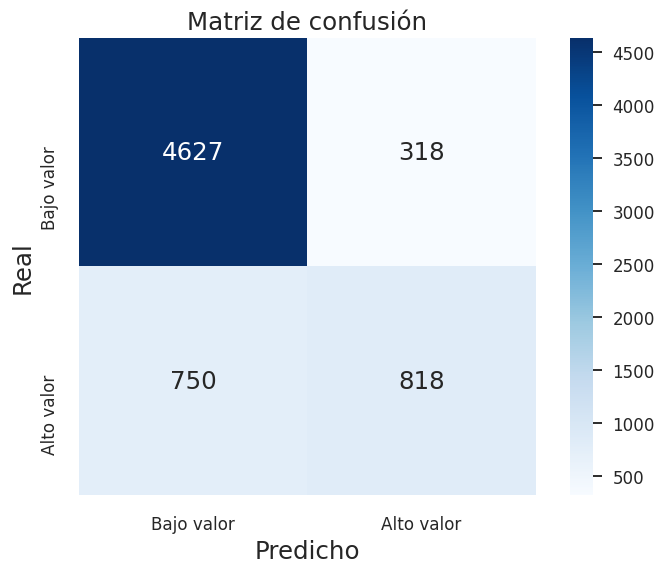

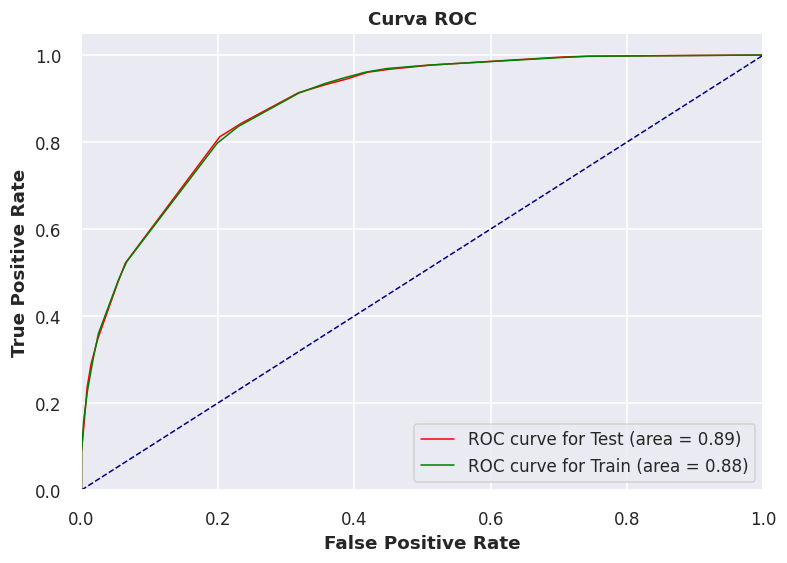

In [5]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_df_numerico, y_df, random_state=10, test_size=0.20, stratify=y_df)

params = {
    'max_depth': np.arange(2, 6),
    'min_samples_leaf': np.arange(500,800,50),
    "criterion": ["gini", "entropy"],
}

clf = tree.DecisionTreeClassifier(random_state=10)
cv_e = StratifiedKFold(n_splits=5).split(XX_train, yy_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

clf.fit(XX_train, yy_train)
yy_pred = clf.predict(XX_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(yy_train, clf.predict_proba(XX_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(yy_pred, yy_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(yy_test, yy_pred)
plot_roc_curves(clf, XX_test, yy_test, XX_train, yy_train)


# Segundo preprocesamiento, RFECV

In [6]:
X_df_numerico = conversion_numerica(X_df) 

AUC-ROC score sobre test:  0.8850805931573844
AUC-ROC score sobre train:  0.8843632504444328
Accuracy sobre test:  0.8360202671579917
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 500}
              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      5377
  Alto valor       0.52      0.72      0.61      1136

    accuracy                           0.84      6513
   macro avg       0.73      0.79      0.75      6513
weighted avg       0.86      0.84      0.85      6513



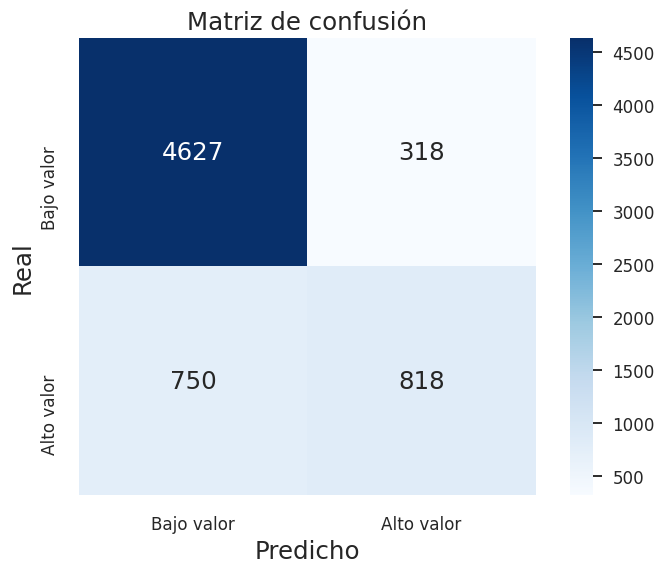

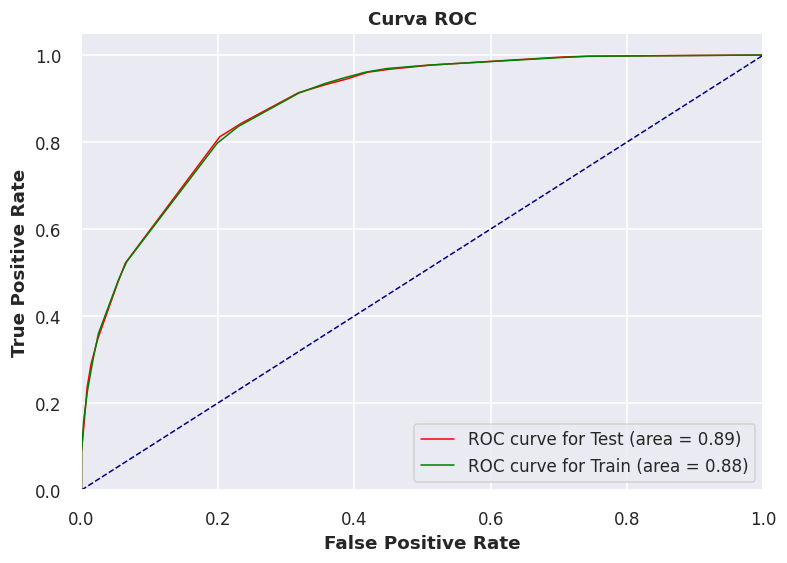

In [7]:

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=10, criterion = 'gini', max_depth = 5, min_samples_leaf =500)
selector = RFECV(
    estimator=clf,
    min_features_to_select=10,
    step=5,
    n_jobs=-1,
    scoring="roc_auc",
    cv=5,
)
selector = selector.fit(X_df_numerico, y_df)

f = selector.get_support(1) 
X_reduced = X_df_numerico[X_df_numerico.columns[f]] 


XX_train, XX_test, yy_train, yy_test = train_test_split(X_reduced, y_df, random_state=10, test_size=0.20, stratify=y_df)

params = {
    'max_depth': np.arange(2, 6),
    'min_samples_leaf': np.arange(500,800,50),
    "criterion": ["gini", "entropy"],
}


cv_e = StratifiedKFold(n_splits=5).split(XX_train, yy_train)
clf = tree.DecisionTreeClassifier(random_state=10)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

clf.fit(XX_train, yy_train)
yy_pred = clf.predict(XX_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(yy_train, clf.predict_proba(XX_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(yy_pred, yy_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(yy_test, yy_pred)
plot_roc_curves(clf, XX_test, yy_test, XX_train, yy_train)


AUC-ROC score sobre test:  0.8849836724376303
AUC-ROC score sobre train:  0.8842508106199527
Accuracy sobre test:  0.8360202671579917
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 500}
              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      5377
  Alto valor       0.52      0.72      0.61      1136

    accuracy                           0.84      6513
   macro avg       0.73      0.79      0.75      6513
weighted avg       0.86      0.84      0.85      6513



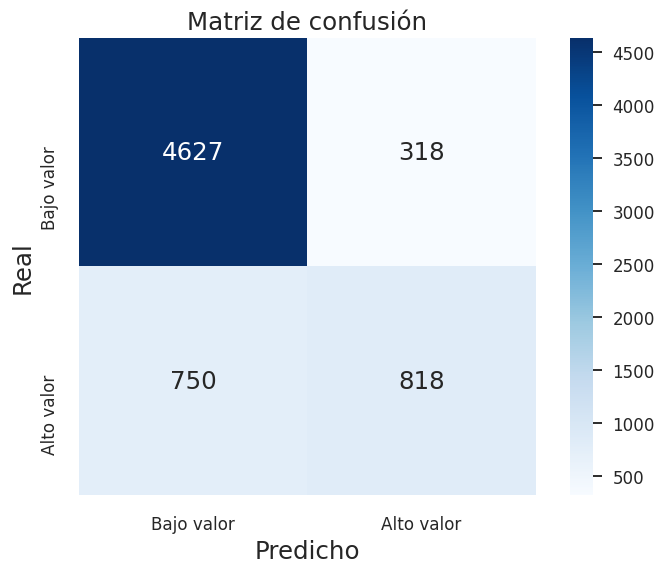

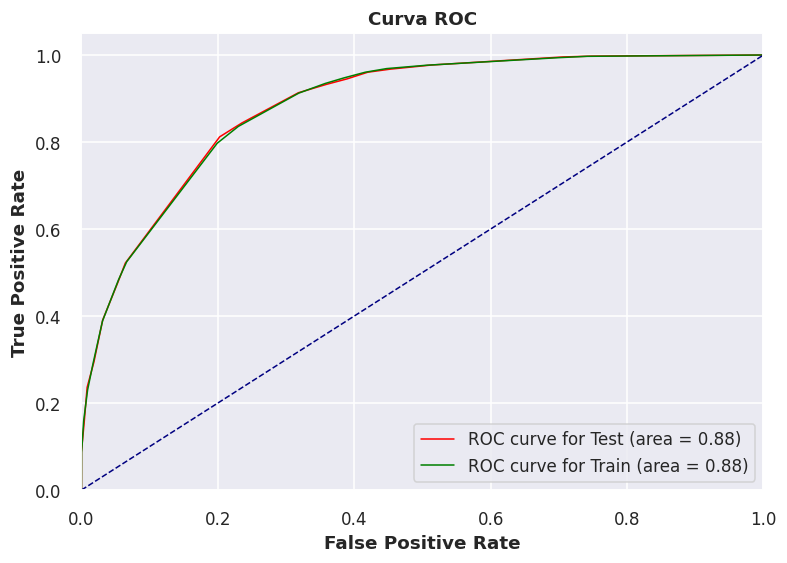

In [8]:

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

clf = tree.DecisionTreeClassifier(random_state=10, criterion = 'gini', max_depth = 5, min_samples_leaf =500)
selector = RFECV(
    estimator=clf,
    min_features_to_select=10,
    step=5,
    n_jobs=-1,
    scoring="roc_auc",
    cv=5,
)
selector = selector.fit(X_df_numerico, y_df)

f = selector.get_support(1) 
X_reduced = X_df_numerico[X_df_numerico.columns[f]] 


XX_train, XX_test, yy_train, yy_test = train_test_split(X_reduced, y_df, random_state=10, test_size=0.20, stratify=y_df)

params = {
    'max_depth': np.arange(2, 6),
    'min_samples_leaf': np.arange(500,800,50),
    "criterion": ["gini", "entropy"],
}


cv_e = StratifiedKFold(n_splits=5).split(XX_train, yy_train)
clf = tree.DecisionTreeClassifier(random_state=10)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

clf.fit(XX_train, yy_train)
yy_pred = clf.predict(XX_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(yy_train, clf.predict_proba(XX_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(yy_pred, yy_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(yy_test, yy_pred)
plot_roc_curves(clf, XX_test, yy_test, XX_train, yy_train)


# Tercer Preprocesamiento, RFECV + PolynomialFeatures de grado 2

In [9]:
X_df_numerico = conversion_numerica(X_df) 

clf = tree.DecisionTreeClassifier(random_state=10, criterion = 'gini', max_depth = 5, min_samples_leaf =500)
selector = RFECV(
    estimator=clf,
    min_features_to_select=5,
    step=5,
    n_jobs=-1,
    scoring="roc_auc",
    cv=5,
)
selector = selector.fit(X_df_numerico, y_df)

f = selector.get_support(1) 
X_reduced = X_df_numerico[X_df_numerico.columns[f]] 
X_reduced.shape

(32561, 5)

In [10]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only = False)
X_reduced_poly = pd.DataFrame(poly.fit_transform(X_reduced))
X_reduced_poly.shape

(32561, 21)

In [11]:
def auc_roc_for(X, y):
    XX_train, XX_test, yy_train, yy_test = train_test_split(X, y, random_state=10, test_size=0.20, stratify=y_df)

    params = {
        'max_depth': np.arange(2, 6),
        'min_samples_leaf': np.arange(500,800,50),
        "criterion": ["gini", "entropy"],
    }

    cv_e = StratifiedKFold(n_splits=5).split(XX_train, yy_train)
    clf_r = tree.DecisionTreeClassifier(random_state=10)
    clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

    clf.fit(XX_train, yy_train)
    yy_pred = clf.predict(XX_test)

    print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
    print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(yy_train, clf.predict_proba(XX_train)[:, 1]))
    print("Los mejores hiperpametros elegidos: ", clf.best_params_)
    '''
    print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(yy_pred, yy_test))
    print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))
    graficar_matriz_confusion(yy_test, yy_pred)
    plot_roc_curves(clf, XX_test, yy_test, XX_train, yy_train)
    '''

In [12]:
auc_roc_for(X_reduced_poly, y_df)

AUC-ROC score sobre test:  0.8849073223829471
AUC-ROC score sobre train:  0.8880425107664478
Los mejores hiperpametros elegidos:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 550}


## Con PolynomialFeatures(2, interaction_only = True)


In [13]:
poly = PolynomialFeatures(2, interaction_only = True)
X_reduced_poly = pd.DataFrame(poly.fit_transform(X_reduced))
X_reduced_poly.shape

(32561, 16)

In [14]:
auc_roc_for(X_reduced_poly, y_df)

AUC-ROC score sobre test:  0.8864677911103774
AUC-ROC score sobre train:  0.8884832292511220
Los mejores hiperpametros elegidos:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 500}


## PolynomialFeatures(3, interaction_only = True)

In [15]:
poly = PolynomialFeatures(3, interaction_only = True)
X_reduced_poly = pd.DataFrame(poly.fit_transform(X_reduced))
X_reduced_poly.shape

(32561, 26)

In [16]:
auc_roc_for(X_reduced_poly, y_df)

AUC-ROC score sobre test:  0.8824932677823404
AUC-ROC score sobre train:  0.8814997592676901
Los mejores hiperpametros elegidos:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 550}


## PolynomialFeatures(3, interaction_only = False)

In [17]:
poly = PolynomialFeatures(3, interaction_only = False)
X_reduced_poly = pd.DataFrame(poly.fit_transform(X_reduced))
X_reduced_poly.shape

(32561, 56)

In [18]:
auc_roc_for(X_reduced_poly, y_df)

AUC-ROC score sobre test:  0.8861107385320155
AUC-ROC score sobre train:  0.8864354749742187
Los mejores hiperpametros elegidos:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 500}


## Aplicando RFCV, Normalization()/Alls, Poly grado 2 interaction_only = False)

In [19]:
scalers = [
    StandardScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
    MinMaxScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    RobustScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
    PowerTransformer(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
    Normalizer(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
]

for count, scaler in enumerate(scalers):
    print("\n---------------------------------------------------------------------")
    print("Aplicando preprocesamiento #",count+1, "con Preprocesamiento de", scaler)
    scaled = scaler.fit_transform(X_reduced)
    X_df_scaled = pd.DataFrame(scaled, index=X_reduced.index, columns=X_reduced.columns)
    poly = PolynomialFeatures(2, interaction_only= False)
    X_df_scaled_poly = pd.DataFrame(poly.fit_transform(X_df_scaled))
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_df_scaled_poly, y_df, random_state=10, test_size=0.20, stratify=y_df)


    params = {
        'max_depth': np.arange(2, 6),
        'min_samples_leaf': np.arange(500,800,50),
        "criterion": ["gini", "entropy"],
    }

    cv_e = StratifiedKFold(n_splits=5).split(XX_train, yy_train)
    clf_r = tree.DecisionTreeClassifier(random_state=10)
    clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

    clf.fit(XX_train, yy_train)
    yy_pred = clf.predict(XX_test)

    print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
    print("Los mejores hiperpametros elegidos: ", clf.best_params_)

    


---------------------------------------------------------------------
Aplicando preprocesamiento # 1 con Preprocesamiento de StandardScaler()
AUC-ROC score sobre test:  0.8874317750355956
Los mejores hiperpametros elegidos:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 500}

---------------------------------------------------------------------
Aplicando preprocesamiento # 2 con Preprocesamiento de MinMaxScaler()
AUC-ROC score sobre test:  0.8855604893625804
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 500}

---------------------------------------------------------------------
Aplicando preprocesamiento # 3 con Preprocesamiento de RobustScaler()
AUC-ROC score sobre test:  0.8834737598274901
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 600}

---------------------------------------------------------------------
Aplicando preprocesamiento # 4 con Preprocesamiento de PowerTra

## Aplicando RFCV, Normalization()/Alls, Poly grado 2, interaction_only = True)

In [20]:
scalers = [
    StandardScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
    MinMaxScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    RobustScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
    PowerTransformer(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
    Normalizer(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
]

for count, scaler in enumerate(scalers):
    print("\n---------------------------------------------------------------------")
    print("Aplicando preprocesamiento #",count+1, "con Preprocesamiento de", scaler)
    scaled = scaler.fit_transform(X_reduced)
    X_df_scaled = pd.DataFrame(scaled, index=X_reduced.index, columns=X_reduced.columns)
    poly = PolynomialFeatures(2, interaction_only=True)
    X_df_scaled_poly = pd.DataFrame(poly.fit_transform(X_df_scaled))
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_df_scaled_poly, y_df, random_state=10, test_size=0.20, stratify=y_df)


    params = {
        'max_depth': np.arange(2, 6),
        'min_samples_leaf': np.arange(500,800,50),
        "criterion": ["gini", "entropy"],
    }

    cv_e = StratifiedKFold(n_splits=5).split(XX_train, yy_train)
    clf_r = tree.DecisionTreeClassifier(random_state=10)
    clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

    clf.fit(XX_train, yy_train)
    yy_pred = clf.predict(XX_test)

    print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
    print("Los mejores hiperpametros elegidos: ", clf.best_params_)

    


---------------------------------------------------------------------
Aplicando preprocesamiento # 1 con Preprocesamiento de StandardScaler()
AUC-ROC score sobre test:  0.8815623645818287
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 500}

---------------------------------------------------------------------
Aplicando preprocesamiento # 2 con Preprocesamiento de MinMaxScaler()
AUC-ROC score sobre test:  0.8855604893625804
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 500}

---------------------------------------------------------------------
Aplicando preprocesamiento # 3 con Preprocesamiento de RobustScaler()
AUC-ROC score sobre test:  0.8832808211757908
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 500}

---------------------------------------------------------------------
Aplicando preprocesamiento # 4 con Preprocesamiento de PowerTransf

## Aplicando RFCV, Normalization()/Alls, Poly grado 3, interaction_only = True)

In [21]:
scalers = [
    StandardScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
    MinMaxScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    RobustScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
    PowerTransformer(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
    Normalizer(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
]

for count, scaler in enumerate(scalers):
    print("\n---------------------------------------------------------------------")
    print("Aplicando preprocesamiento #",count+1, "con Preprocesamiento de", scaler)
    scaled = scaler.fit_transform(X_reduced)
    X_df_scaled = pd.DataFrame(scaled, index=X_reduced.index, columns=X_reduced.columns)
    poly = PolynomialFeatures(3,interaction_only = True)
    X_df_scaled_poly = pd.DataFrame(poly.fit_transform(X_df_scaled))
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_df_scaled_poly, y_df, random_state=10, test_size=0.20, stratify=y_df)

    params = {
        'max_depth': np.arange(2, 6),
        'min_samples_leaf': np.arange(500,800,50),
        "criterion": ["gini", "entropy"],
    }

    clf = tree.DecisionTreeClassifier(random_state=10)
    clf = GridSearchCV(clf, params, scoring='f1', cv=5, n_jobs = -1)

    clf.fit(XX_train, yy_train)
    yy_pred = clf.predict(XX_test)

    print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
    print("Los mejores hiperpametros elegidos: ", clf.best_params_)
    


---------------------------------------------------------------------
Aplicando preprocesamiento # 1 con Preprocesamiento de StandardScaler()
AUC-ROC score sobre test:  0.8444434700068095
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 650}

---------------------------------------------------------------------
Aplicando preprocesamiento # 2 con Preprocesamiento de MinMaxScaler()
AUC-ROC score sobre test:  0.8824959116609232
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 500}

---------------------------------------------------------------------
Aplicando preprocesamiento # 3 con Preprocesamiento de RobustScaler()
AUC-ROC score sobre test:  0.7502959209467407
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 550}

---------------------------------------------------------------------
Aplicando preprocesamiento # 4 con Preprocesamiento de PowerTransf

# Preprocesamiento con clusters según lo estudiado en el notebook 'tp_FIUFIP_parte1_extras'

In [22]:
def one_hot_clusters_dbscan(df, eps, min_samples):
    model = DBSCAN(algorithm='kd_tree', eps=eps, min_samples=min_samples)
    df = pd.DataFrame(df)
    df['cluster_dbscan'] = model.fit_predict(df)
    df = pd.get_dummies(df, drop_first=True, columns=['cluster_dbscan'])
    return df

In [23]:
X_df_numerico = conversion_numerica(X_df) 

scaled = MinMaxScaler().fit_transform(X_df_numerico)
X_df_numerico_scaled = pd.DataFrame(scaled, index=X_df_numerico.index, columns=X_df_numerico.columns)

svd = TruncatedSVD(n_components=22, n_iter=7, random_state=10)
X_df_numerico_scaled_svd = pd.DataFrame(svd.fit_transform(X_df_numerico_scaled))

X_df_numerico_scaled_svd_oe = one_hot_clusters_dbscan(X_df_numerico_scaled_svd, 0.3, 3)
X_df_numerico_scaled_svd_oe.shape

(32561, 977)

AUC-ROC score sobre test:  0.8606085950558180
AUC-ROC score sobre train:  0.8646137732738970
Accuracy sobre test:  0.8197451251343467
Los mejores hiperpametros elegidos:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 550}
              precision    recall  f1-score   support

  Bajo valor       0.90      0.87      0.88      5109
  Alto valor       0.57      0.64      0.60      1404

    accuracy                           0.82      6513
   macro avg       0.74      0.75      0.74      6513
weighted avg       0.83      0.82      0.82      6513



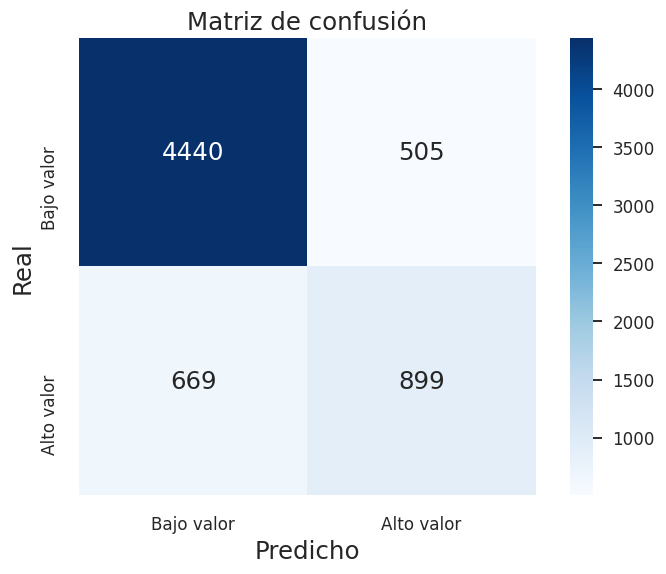

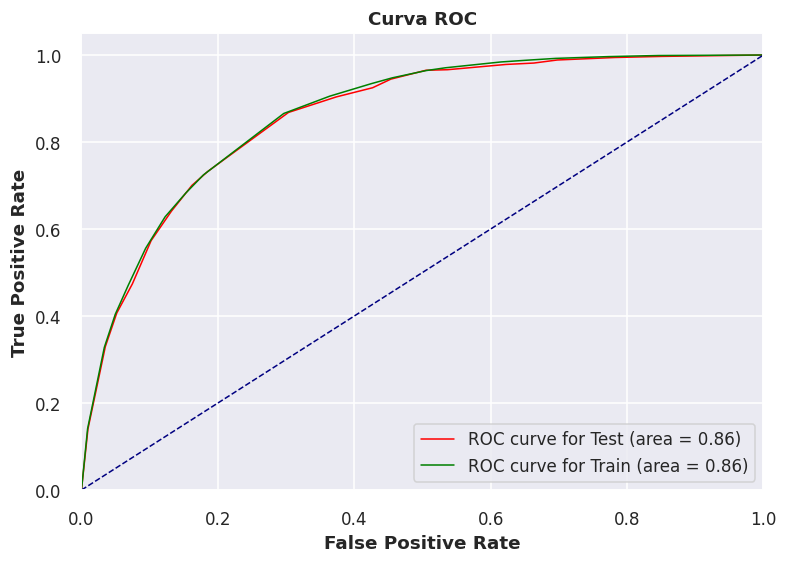

In [24]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_df_numerico_scaled_svd_oe, y_df, random_state=10, test_size=0.20, stratify=y_df)

params = {
    'max_depth': np.arange(2, 6),
    'min_samples_leaf': np.arange(500,800,50),
    "criterion": ["gini", "entropy"],
}

clf = tree.DecisionTreeClassifier(random_state=10)
cv_e = StratifiedKFold(n_splits=5).split(XX_train, yy_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

clf.fit(XX_train, yy_train)
yy_pred = clf.predict(XX_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(yy_train, clf.predict_proba(XX_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(yy_pred, yy_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(yy_test, yy_pred)
plot_roc_curves(clf, XX_test, yy_test, XX_train, yy_train)


# Preprocesamiento con: expansion_numerica_reducida()

In [40]:
def get_dataframe_scaled(df, scaler_r):
    scaled = scaler_r.fit_transform(df)
    return pd.DataFrame(scaled, index = df.index, columns = df.columns)

from sklearn.feature_selection import VarianceThreshold

def filter_by_variance(df, threshold):
    cols_con_varianza = df.var().index.values
    _df = df[cols_con_varianza].copy()
    selector = VarianceThreshold(threshold=threshold)
    vt = selector.fit(_df)
    _df = _df.loc[:, vt.get_support()]
    return _df

def get_dataframe_polynomial(df, grade_r, interaction_only_r):
    poly = PolynomialFeatures(grade_r, interaction_only = interaction_only_r)
    return pd.DataFrame(poly.fit_transform(df))  

def expansion_numerica_reducida(X_df, componentes_primera_etapa = 23, componentes_finales = 68):
    scaled = MinMaxScaler().fit_transform(X_df)
    print('MinMaxScaler aplicado...')
    X_df_numerico_scaled = pd.DataFrame(scaled, index=X_df_numerico.index, columns=X_df_numerico.columns)
    svd = TruncatedSVD(n_components=componentes_primera_etapa, n_iter=7, random_state=10)
    X_df_numerico_scaled_svd = pd.DataFrame(svd.fit_transform(X_df_numerico_scaled))
    print('1° TruncatedSVD con', componentes_primera_etapa,'componentes finales se explica una varianza de: %.10f' % svd.explained_variance_ratio_.sum())
    X_df_numerico_poly = get_dataframe_polynomial(X_df_numerico_scaled_svd, 2, False)
    X_df_numerico_poly = filter_by_variance(X_df_numerico_poly, 0)
    print('PolynomialFeatures grado 2 aplicado se obtienen', len(X_df_numerico_poly.columns), 'nuevas componentes...')
    svd = TruncatedSVD(n_components=componentes_finales, n_iter=7, random_state=10)
    X_df_expandido = pd.DataFrame(svd.fit_transform(X_df_numerico_poly))
    print('2° TruncatedSVD con',  componentes_finales, 'componentes finales se explica una varianza de: %.10f' % svd.explained_variance_ratio_.sum())
    return X_df_expandido

def reduccion_numerica(X_df, componentes_finales = 23):
    scaled = MinMaxScaler().fit_transform(X_df)
    X_df_numerico_scaled = pd.DataFrame(scaled, index=X_df_numerico.index, columns=X_df_numerico.columns)

    svd = TruncatedSVD(n_components=componentes_finales, n_iter=7, random_state=10)
    X_df_numerico_scaled_svd = pd.DataFrame(svd.fit_transform(X_df_numerico_scaled))
    print('TruncatedSVD con',  componentes_finales, 'componentes finales se explica una varianza de: %.10f' % svd.explained_variance_ratio_.sum())
    return X_df_numerico_scaled_svd

In [41]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r) 
X_df_expandido = expansion_numerica_reducida(X_df_numerico, 39, 298)

MinMaxScaler aplicado...
1° TruncatedSVD con 39 componentes finales se explica una varianza de: 1.0000000000
PolynomialFeatures grado 2 aplicado se obtienen 819 nuevas componentes...
2° TruncatedSVD con 298 componentes finales se explica una varianza de: 0.9959090592


AUC-ROC score sobre test:  0.8599125456552692
AUC-ROC score sobre train:  0.8658208568699802
Accuracy sobre test:  0.8218946721940734
Los mejores hiperpametros elegidos:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 500}
              precision    recall  f1-score   support

  Bajo valor       0.94      0.84      0.89      5541
  Alto valor       0.44      0.71      0.54       972

    accuracy                           0.82      6513
   macro avg       0.69      0.78      0.72      6513
weighted avg       0.87      0.82      0.84      6513



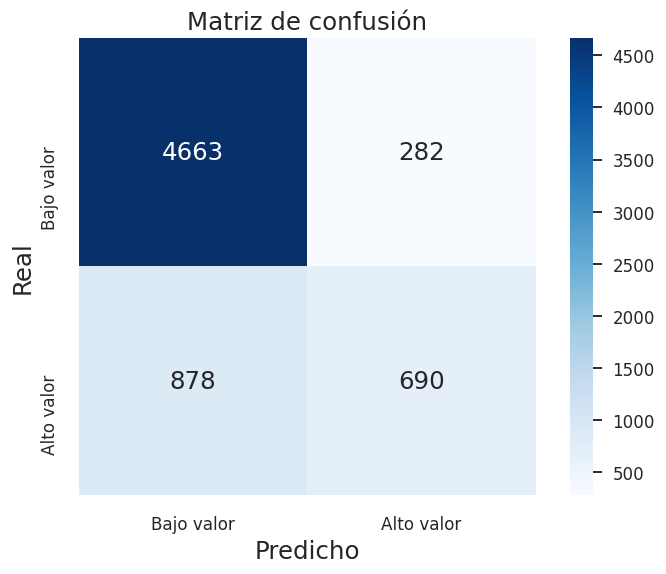

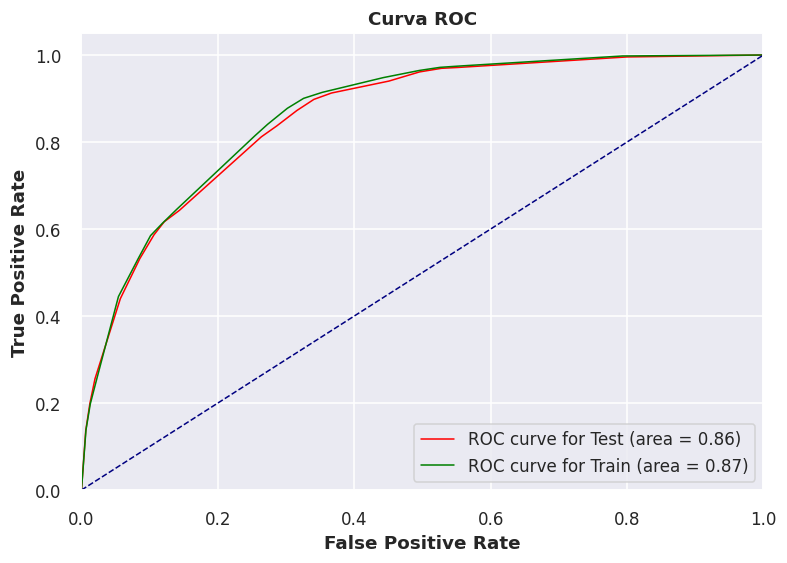

In [42]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_df_expandido, y_df, random_state=10, test_size=0.20, stratify=y_df)

params = {
    'max_depth': np.arange(2, 6),
    'min_samples_leaf': np.arange(500,800,50),
    "criterion": ["gini", "entropy"],
}

clf = tree.DecisionTreeClassifier(random_state=10)
cv_e = StratifiedKFold(n_splits=5).split(XX_train, yy_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

clf.fit(XX_train, yy_train)
yy_pred = clf.predict(XX_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(yy_train, clf.predict_proba(XX_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(yy_pred, yy_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(yy_test, yy_pred)
plot_roc_curves(clf, XX_test, yy_test, XX_train, yy_train)
